In [ ]:
import numpy as np
import nltk
from nltk import bigrams
import itertools
import pandas as pd
import tqdm
import torch
from torch import nn
import torch.optim as optim

from collections import Counter
import gensim.downloader as api
from gensim.models import Word2Vec
dataset = api.load("text8")
model = Word2Vec(dataset)

In [ ]:
corpus = []
for el in dataset:
    corpus.append('<SOS>')
    corpus.extend(el)
    corpus.append('<EOS>')

In [ ]:
word_count = Counter(corpus)

In [ ]:
len(word_count)

In [ ]:
word_count = { wd: count for wd, count in word_count.items() if count >= 1000 and len(wd) > 1}


In [ ]:
num_words = len(word_count)
num_words

In [ ]:
filtered_corpus = [wd for wd in corpus if wd in word_count.keys()]

In [ ]:
len(corpus)

In [ ]:
len(filtered_corpus)

In [ ]:
!pip install nltk

In [ ]:


def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index


matrix, vocab_index = generate_co_occurrence_matrix(filtered_corpus)

data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

In [ ]:
class GloVe(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.emb = nn.Embedding(n_vocab, n_embed)
        self.bias = torch.autograd.Variable(torch.zeros(n_vocab), requires_grad=True)
    
    def forward(self, idx1, idx2):
        # idx1 shape: batch size, 
        # w1 shape: batch size, n_embed
        w1 = self.emb(idx1)
        w2 = self.emb(idx2)
        
        # b1 shape: batch size
        b1 = self.bias[idx1]
        b2 = self.bias[idx2]
        
        forecast = torch.sum(w1 * w2, axis=1) + b1 + b2
        return forecast
        
    def get_emb(self):
        return self.emb.weight.data.cpu().numpy()
    
def f(x, alpha = .75, xmax = 100):
    return np.minimum(1, (x/xmax)**alpha)

In [ ]:
n_embed = 32
n_vocab = len(vocab_index)
mdl = GloVe(n_vocab, n_embed)

In [ ]:
mdl(torch.LongTensor(np.arange(3)), torch.LongTensor(np.arange(3)+4))

In [ ]:
losses = []
batch_size = 256
EPSILON = 1e-6
optimizer = optim.Adam(mdl.parameters(), lr=0.003)
for itr in range(10000):
    word_left = np.random.choice(num_words, size = batch_size, replace=False)
    word_right = np.random.choice(num_words, size = batch_size, replace=False)
    correct_value = data_matrix.values[word_left, word_right]
    model_prediction = mdl(torch.LongTensor(word_left), torch.LongTensor(word_right))
    f_weight = torch.FloatTensor(f(correct_value))
    mse = (model_prediction - torch.log(torch.FloatTensor(correct_value)+EPSILON)) ** 2
    loss_raw = f_weight * mse
    loss = loss_raw.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(float(loss.data.numpy()))

In [ ]:
pd.Series(losses).plot(backend='plotly')

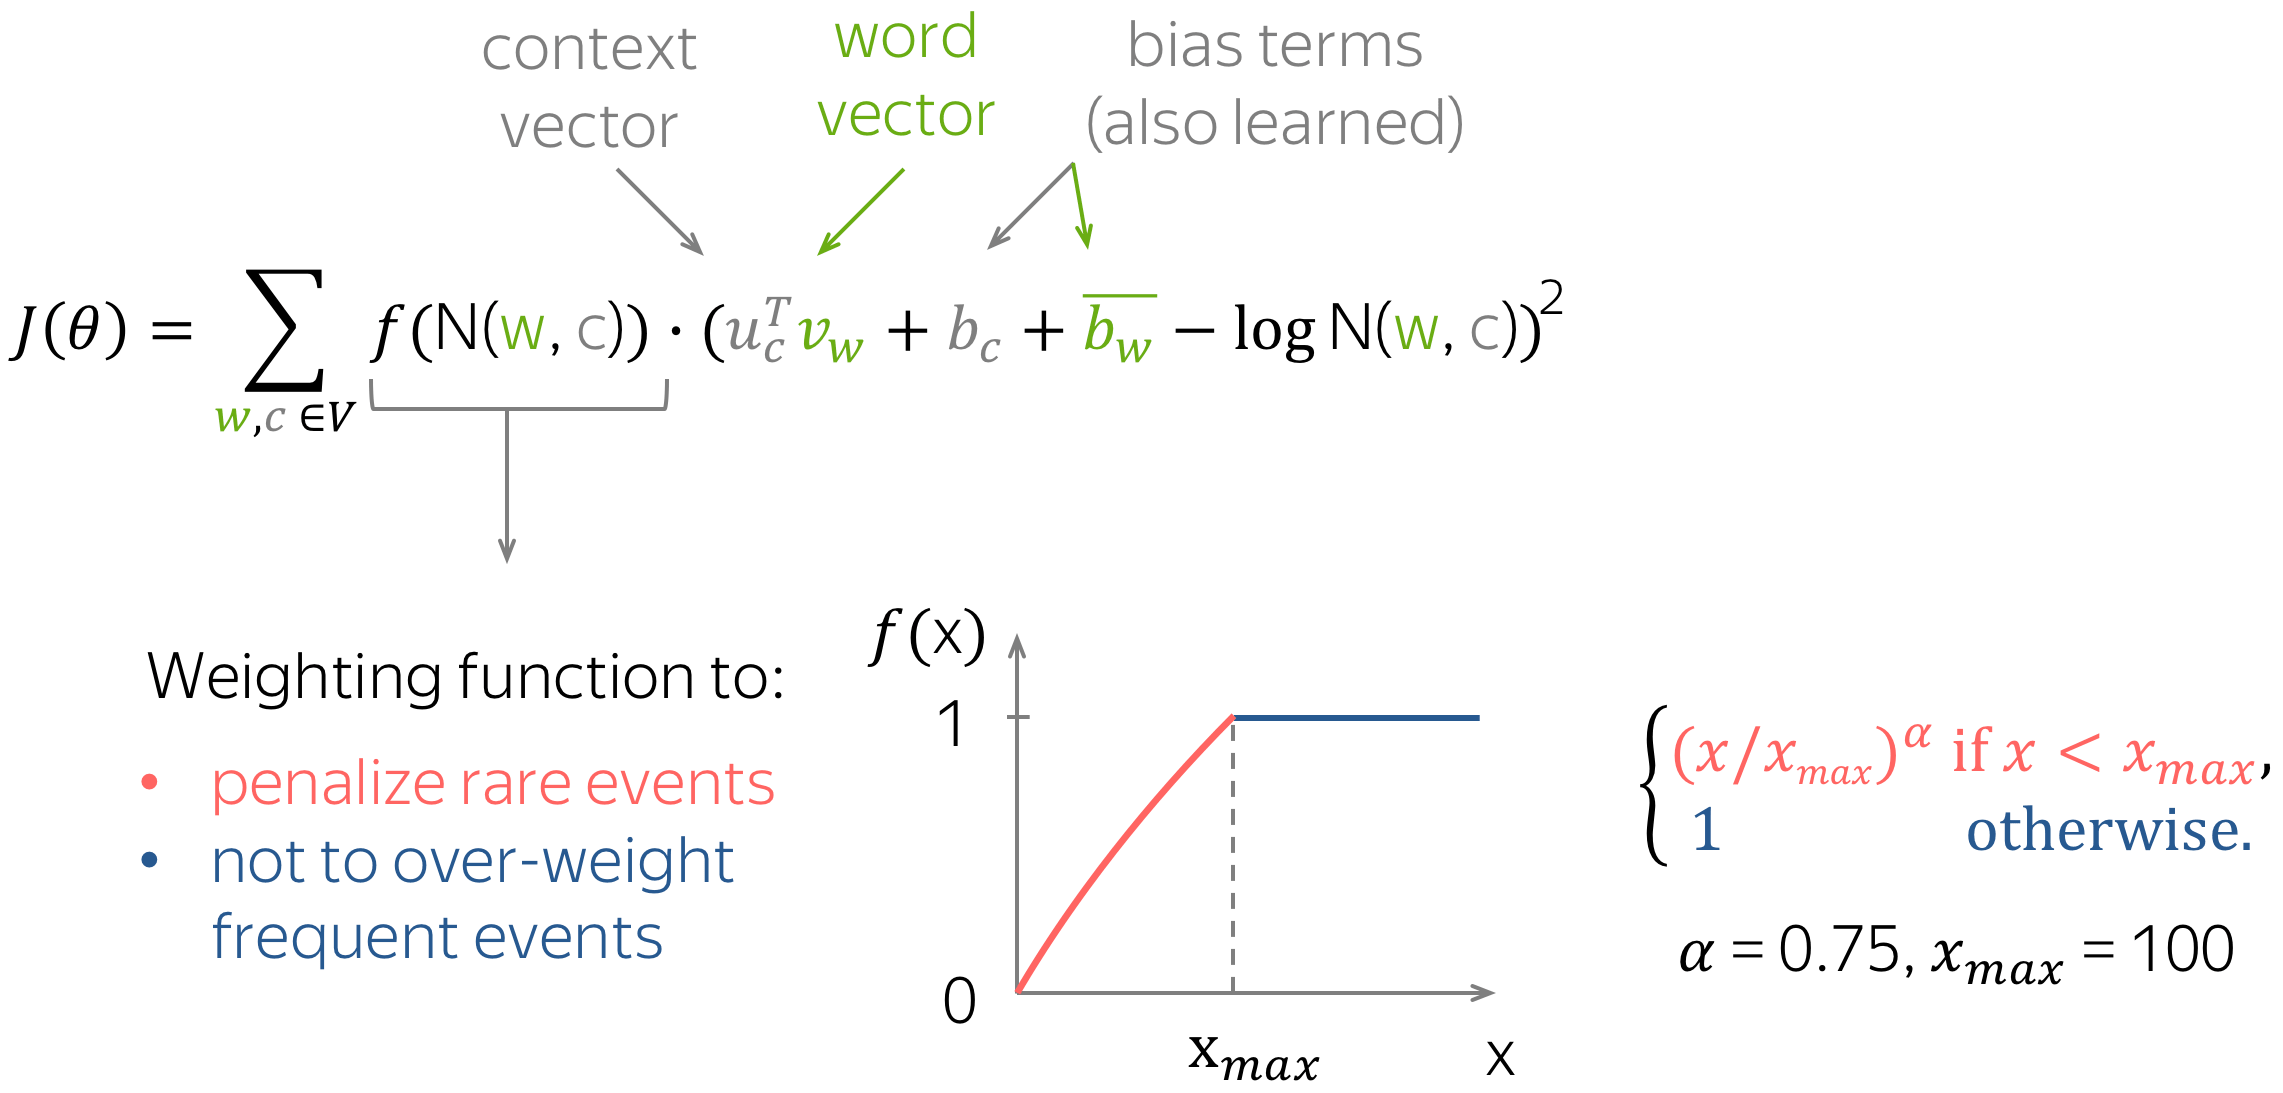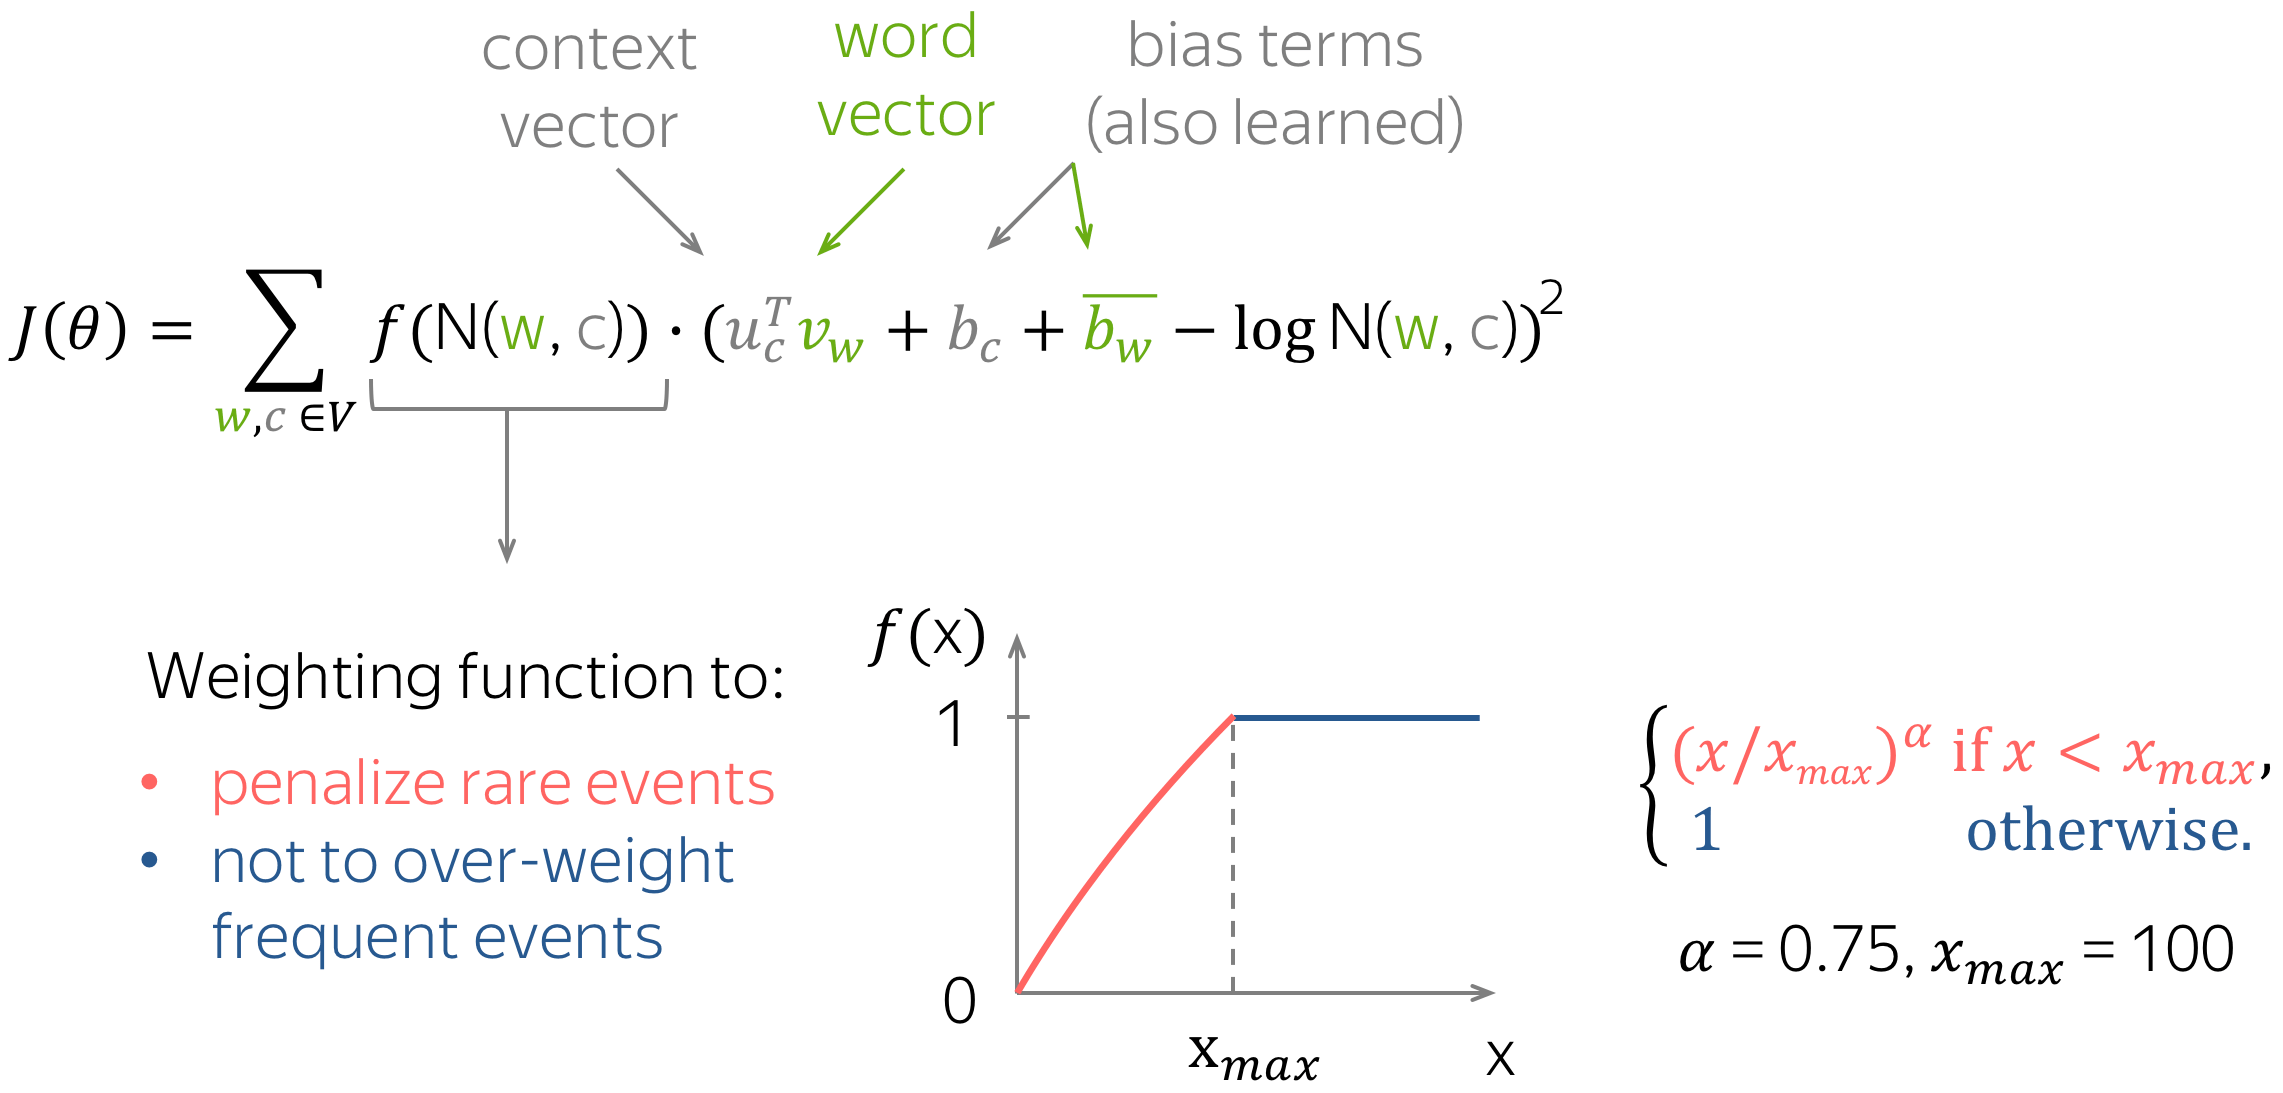

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = mdl.emb.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

In [ ]:
int_to_vocab = {id:wd for id, wd in enumerate(data_matrix.columns)}

In [ ]:
k_idx, q_idx, m_idx, w_idx = [data_matrix.columns.to_list().index(wd) for wd in [
    'king', 'queen', 'man', 'woman']]

In [ ]:
analogy_emb = embeddings[[k_idx, q_idx, m_idx, w_idx]]

In [ ]:
w_pred = analogy_emb[1] - analogy_emb[0] + analogy_emb[2]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)